In [ ]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/unzipped/"

Archive:  /content/drive/MyDrive/Colab Notebooks/archive.zip
replace /content/drive/MyDrive/Colab Notebooks/unzipped/PlantVillage/PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install keras-tuner -q

In [ ]:
!pip install --upgrade jax jaxlib

In [28]:
!pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 22.3 MB/s eta 0:00:00


#*필요한 라이브러리*

In [29]:
# 데이터 조작
import numpy as np
import pandas as pd

# 데이터 시각화
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib
from PIL import Image
import torch
import torchvision
import sqlite3
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from pymongo import MongoClient

# DL 라이브러리
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tensorflow.keras.models import Model



from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2

# 기타 라이브러리
import os
import random
import logging

탐색적 데이터 분석

In [ ]:
# 데이터 경로 설정
data_dir = '/content/drive/MyDrive/Colab Notebooks/archive/PlantVillage/PlantVillage'
test_dir = '/content/drive/MyDrive/Colab Notebooks/archive/PotatoPlants'

#*이미지 파일 목록 가져오기*

In [ ]:
# 이미지 파일 목록 가져오기
image_paths = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg"):  # 이미지 확장자 확인
            image_paths.append(os.path.join(root, file))

random.shuffle(image_paths)

#*데이터 로드 및 분포 시각화*

클래스별 이미지 수: {'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Potato___healthy': 152}


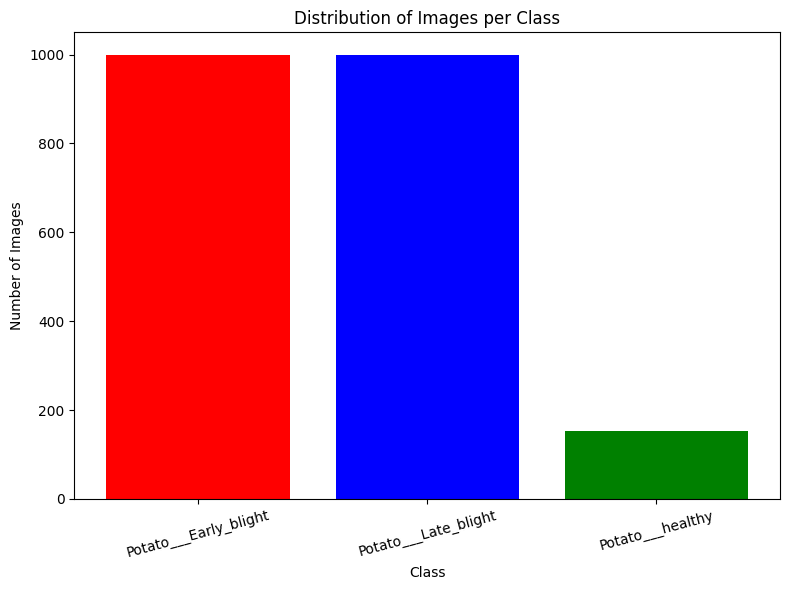

In [ ]:
# 실제 클래스 이름
classes = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
# 클래스별 이미지 수 계산
class_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if not os.path.exists(class_path):
        print(f"[경고] 폴더 없음: {class_path}")
        class_counts[cls] = 0
        continue

    image_files = [file for file in os.listdir(class_path) if file.lower().endswith('.jpg')]
    class_counts[cls] = len(image_files)

print("클래스별 이미지 수:", class_counts)

# 시각화
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['red', 'blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#*데이터 로딩 & 전처리 & DataLoader*

In [ ]:
# 클래스 이름
classes = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# 전처리 및 증강
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 전체 데이터셋
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# 훈련/검증 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform  # 검증은 증강 제외

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes  # ['Potato___Early_blight', ...]

#*무작위 학습 이미지 시각화 (정규화 해제 포함)*

In [ ]:
def show_batch_images(dataloader, num_images=12):
    for images, labels in dataloader:
        images = images[:num_images]
        labels = labels[:num_images]
        break

    cols = 4
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i in range(num_images):
        image = images[i]
        label = labels[i]

        # 정규화 해제
        image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        image = torch.clamp(image, 0, 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.title(class_names[label], fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 호출
show_batch_images(train_loader)

Output hidden; open in https://colab.research.google.com to view.

#*무작위 12장, Green 채널, 히트맵 시각화*

In [ ]:
# 클래스명 리스트
class_names = full_dataset.classes

# 배치 하나 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)  # images.shape: [B, C, H, W]

# 무작위 12개 선택
indices = torch.randperm(images.size(0))[:12]
images = images[indices]
labels = labels[indices]

# 시각화
cols = 4
rows = 3
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i in range(12):
    green_channel = images[i][1].cpu()  # Green 채널만 사용
    ax = axs[i // cols][i % cols]
    ax.imshow(green_channel, cmap='viridis')  # 히트맵 느낌
    ax.set_title(f"Label: {class_names[labels[i]]}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#*설정값*

In [ ]:
# 하이퍼파라미터
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 25

# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

# 클래스명 (ImageFolder 기준)
classes = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
NUM_CLASSES = len(classes)

#*증강 + 데이터로더 구성 (shuffle 포함)*

In [ ]:
# 전처리 및 증강
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 전체 데이터셋
dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# 훈련/검증 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 클래스 인덱스 이름 추출
class_names = dataset.classes

In [ ]:
# 검증 데이터를 위한 ImageDataGenerator 생성
validation_datagen = ImageDataGenerator(rescale=1./255)  # 필요에 따라 다른 전처리 단계 추가 가능

# validation_generator 생성
validation_generator = validation_datagen.flow_from_directory(
    test_dir,  # 검증 데이터 디렉토리 경로
    target_size=(224, 224),  # 모델 입력 크기에 맞게 조정
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # 분류 작업에 맞게 조정
)

Found 2151 images belonging to 3 classes.


#*학습 함수 (공통)*

In [ ]:
def train_model(model, epochs=EPOCHS):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}")

#*Confusion Matrix 시각화 함수*

In [ ]:
def plot_confusion_matrix(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

#*데이터 제너레이터 구성*

In [ ]:
# train_generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# test_generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# validation_generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    test_dir, # 검증 데이터는 test_dir에서 가져옴
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # 검증 데이터는 섞지 않음
)

Found 2152 images belonging to 3 classes.
Found 2151 images belonging to 3 classes.
Found 2151 images belonging to 3 classes.


#*VGG16  전이 학습 (Transfer Learning)*

In [ ]:
# VGG16 사전학습 모델 불러오기
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 전이 학습: 모든 층 동결
for layer in vgg_base.layers:
    layer.trainable = False

# 출력층 구성
x = Flatten()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout으로 과적합 방지
output = Dense(len(class_names), activation='softmax')(x)  # class_names는 flow_from_directory 기준

# 모델 정의
vgg_model = Model(inputs=vgg_base.input, outputs=output)

# 컴파일
vgg_model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
# 학습
print("\nTraining VGG16 model (Transfer Learning)...")
vgg_history = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
def plot_history(history, title):
  """Plots the training and validation accuracy and loss curves.

  Args:
    history: The training history object returned by model.fit.
    title: The title of the plot.
  """
  plt.figure(figsize=(10, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{title} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'{title} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


# 테스트셋 평가
print("\nEvaluating VGG16 (Transfer Learning) on Test Set...")
loss, accuracy = vgg_model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


Training VGG16 model (Transfer Learning)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.5202 - loss: 0.9709 - val_accuracy: 0.7964 - val_loss: 0.6579
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.7393 - loss: 0.6510 - val_accuracy: 0.8587 - val_loss: 0.4927
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 490ms/step - accuracy: 0.7941 - loss: 0.5601 - val_accuracy: 0.8945 - val_loss: 0.4036
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 472ms/step - accuracy: 0.8449 - loss: 0.4419 - val_accuracy: 0.9126 - val_loss: 0.3386
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy: 0.8663 - loss: 0.3962 - val_accuracy: 0.9256 - val_loss: 0.2972
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.8821 - loss: 0.3465 - val_accuracy: 0.9279 - val_loss: 0.2722
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - accuracy: 0.9016 - loss: 0.3141 - val_accuracy: 0.9372 - val_loss: 0.2484
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0.8927 - loss: 0.3036 - val_accu

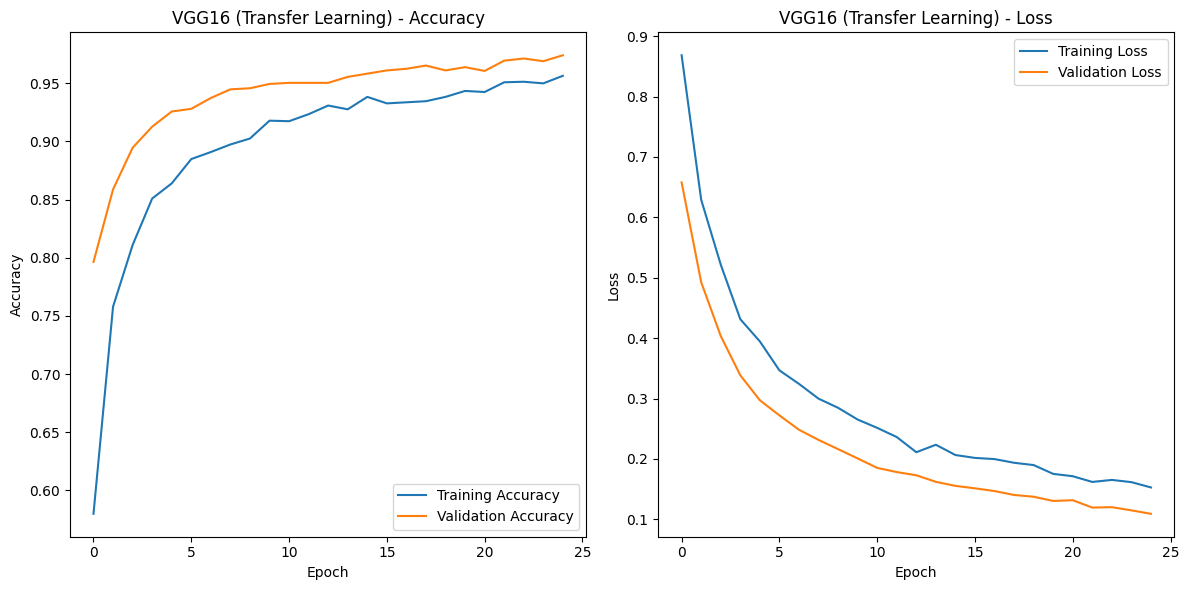

In [ ]:
# 학습 그래프 시각화 함수
def plot_history(history, title):
    """Plots the training and validation accuracy and loss curves.

    Args:
      history: The training history object returned by model.fit.
      title: The title of the plot.
    """
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 학습 후 시각화
plot_history(vgg_history, "VGG16 (Transfer Learning)")

68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step


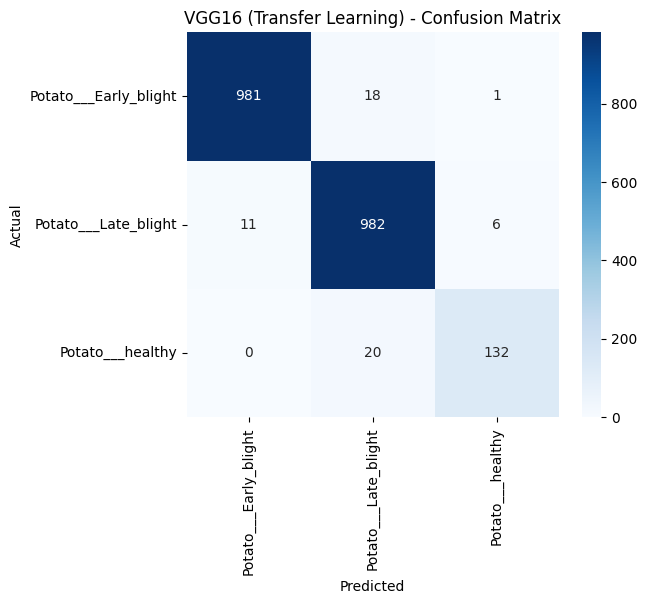

In [ ]:
# 실제 클래스와 예측 클래스 얻기
y_true = test_generator.classes  # 실제 클래스
y_pred_probs = vgg_model.predict(test_generator)  # 예측 확률
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측 레이블

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 클래스 이름을 명시적으로 설정
class_names = list(test_generator.class_indices.keys())  # test_generator에서 클래스 이름을 가져옵니다.

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,  # 클래스 이름 설정
            yticklabels=class_names)  # 클래스 이름 설정
plt.title('VGG16 (Transfer Learning) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#*VGG16 모델 - 파인튜닝 (Fine-Tuning)*

In [ ]:
# VGG16 모델 불러오기 (파인튜닝)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tuning: block5_conv1부터 학습 가능하도록 설정
set_trainable = False
for layer in vgg_base.layers:
    if layer.name == 'block5_conv1':  # 이 지점부터 학습 가능하도록 설정
        set_trainable = True
    layer.trainable = set_trainable

# 출력층 구성
x = Flatten()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)  # class_names는 train_generator에서 가져옴

# Fine-Tuning 모델 정의
vgg_ft_model = Model(inputs=vgg_base.input, outputs=output)

# 컴파일 (Fine-Tuning일 때 학습률은 작게 설정)
vgg_ft_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
# 학습
print("\nFine-Tuning VGG16 model...")
from tensorflow.keras.callbacks import EarlyStopping # Importing EarlyStopping
vgg_ft_history = vgg_ft_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Fine-Tuning VGG16 model...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 493ms/step - accuracy: 0.5785 - loss: 1.0037 - val_accuracy: 0.8819 - val_loss: 0.4211
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 470ms/step - accuracy: 0.8187 - loss: 0.4556 - val_accuracy: 0.9121 - val_loss: 0.2491
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0.9075 - loss: 0.2697 - val_accuracy: 0.9503 - val_loss: 0.1558
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy: 0.9323 - loss: 0.1837 - val_accuracy: 0.9623 - val_loss: 0.1118
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 475ms/step - accuracy: 0.9467 - loss: 0.1577 - val_accuracy: 0.9707 - val_loss: 0.0868
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - accuracy: 0.9536 - loss: 0.1269 - val_accuracy: 0.9763 - val_loss: 0.0695
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 476ms/step - accuracy: 0.9681 - loss: 0.0920 - val_accuracy: 0.9823 - val_loss: 0.0503
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 468ms/step - accuracy: 0.96

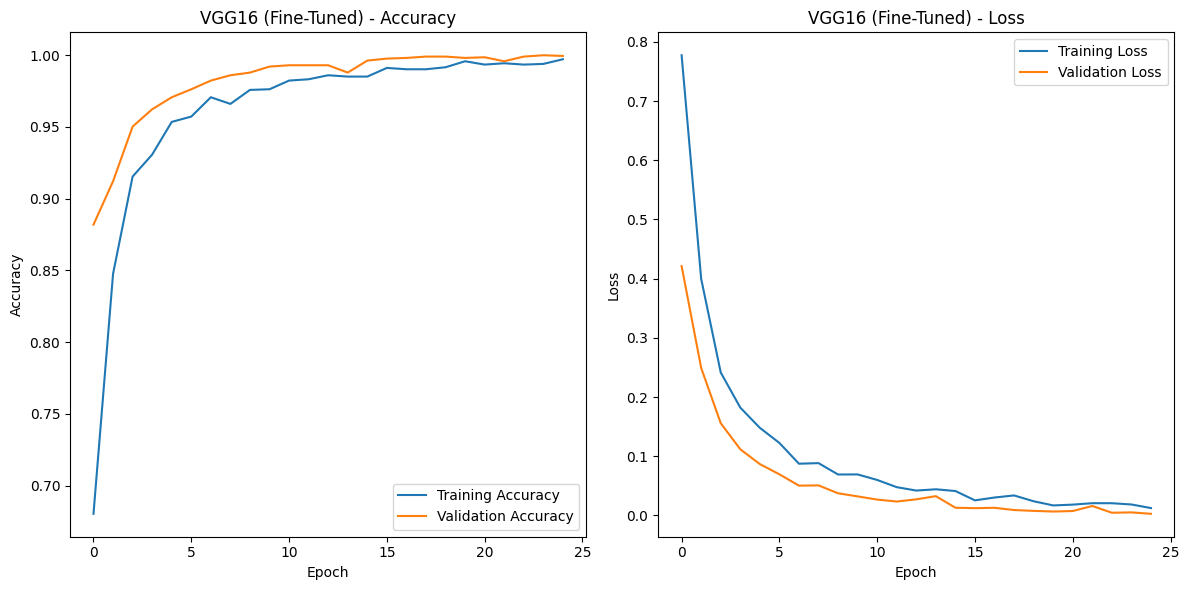

In [ ]:
# 학습 그래프 시각화 함수
def plot_history1(history, title):
    """Plots the training and validation accuracy and loss curves.

    Args:
      history: The training history object returned by model.fit.
      title: The title of the plot.
    """
    plt.figure(figsize=(12, 6))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 학습 후 시각화
plot_history1(vgg_ft_history, "VGG16 (Fine-Tuned)")

In [ ]:
# 테스트셋 평가
print("\nEvaluating Fine-Tuned VGG16 on Test Set...")
loss, accuracy = vgg_ft_model.evaluate(test_generator)
print(f"\nVGG16 Fine-Tuned Test Accuracy: {accuracy:.4f}")
print(f"VGG16 Fine-Tuned Test Loss: {loss:.4f}")


Evaluating Fine-Tuned VGG16 on Test Set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9995 - loss: 0.0026

VGG16 Fine-Tuned Test Accuracy: 0.9995
VGG16 Fine-Tuned Test Loss: 0.0028


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step


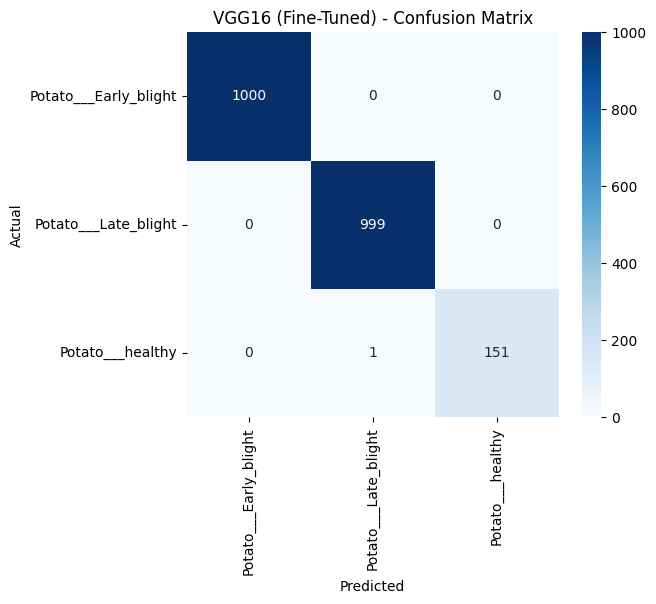

In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes
y_pred_probs = vgg_ft_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('VGG16 (Fine-Tuned) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#*ResNet50-전이 학습 (Transfer Learning)*

In [ ]:
# ResNet50 모델 불러오기 (전이 학습)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모든 층 동결
for layer in resnet_base.layers:
    layer.trainable = False

# 출력층 구성 (128 뉴런으로 변경)
x = Flatten()(resnet_base.output)
x = Dense(128, activation='relu')(x)  # Dense(128, activation='relu')로 수정
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(class_names), activation='softmax')(x)

# 모델 정의
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# 모델 컴파일
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step



Training ResNet50 model (Transfer Learning)...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 608ms/step - accuracy: 0.4964 - loss: 1.1058 - val_accuracy: 0.7778 - val_loss: 0.7477
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 475ms/step - accuracy: 0.7074 - loss: 0.7575 - val_accuracy: 0.7652 - val_loss: 0.6905
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 475ms/step - accuracy: 0.7243 - loss: 0.7343 - val_accuracy: 0.7624 - val_loss: 0.6639
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 474ms/step - accuracy: 0.7502 - loss: 0.6900 - val_accuracy: 0.7624 - val_loss: 0.6501
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 481ms/step - accuracy: 0.7651 - loss: 0.6691 - val_accuracy: 0.7801 - val_loss: 0.6130
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 472ms/step - accuracy: 0.7531 - loss: 0.6569 - val_accuracy: 0.7741 - val_loss: 0.6068
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - accuracy: 0.7608 - loss: 0.6547 - val_accuracy: 0.8085 - val_loss: 0.5529
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 474ms/s

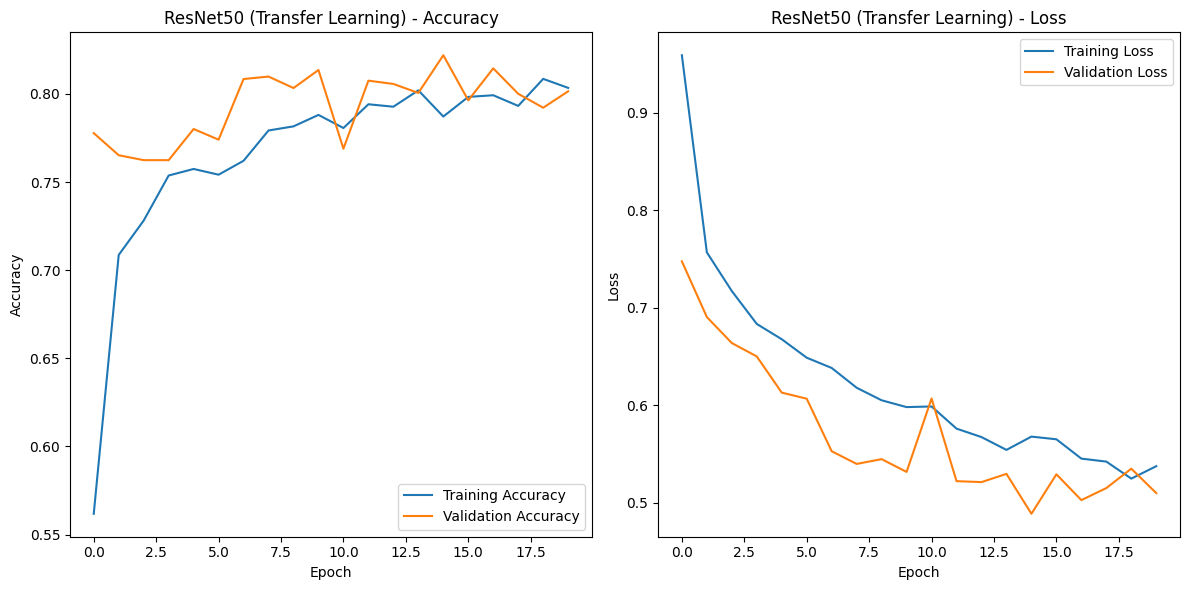


Evaluating ResNet50 on Test Set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9096 - loss: 0.3204

ResNet50 Test Accuracy: 0.8219
ResNet50 Test Loss: 0.4887


In [ ]:
# 학습
print("\nTraining ResNet50 model (Transfer Learning)...")
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
plot_history(resnet_history, "ResNet50 (Transfer Learning)")

# 테스트셋 평가
print("\nEvaluating ResNet50 on Test Set...")
loss, accuracy = resnet_model.evaluate(test_generator)
print(f"\nResNet50 Test Accuracy: {accuracy:.4f}")
print(f"ResNet50 Test Loss: {loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step


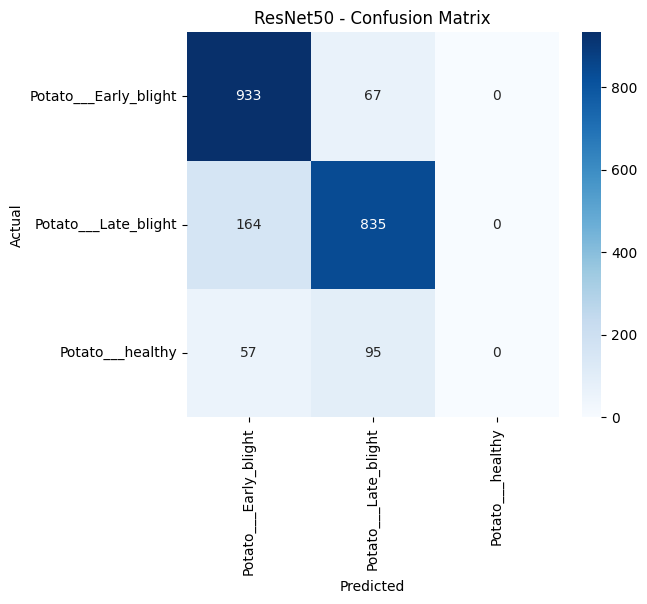


Classification Report for ResNet50 (Transfer Learning):
                       precision    recall  f1-score   support

Potato___Early_blight       0.81      0.93      0.87      1000
 Potato___Late_blight       0.84      0.84      0.84       999
     Potato___healthy       0.00      0.00      0.00       152

             accuracy                           0.82      2151
            macro avg       0.55      0.59      0.57      2151
         weighted avg       0.76      0.82      0.79      2151


[ResNet50 Transfer Learning 모델 분석 요약]
- Test Accuracy: 82.19%
- Test Loss: 0.4887


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes
y_pred_probs = resnet_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 분류 리포트
print(f"\nClassification Report for ResNet50 (Transfer Learning):")
print(classification_report(y_true, y_pred, target_names=class_names))

# 분석 설명
print("\n[ResNet50 Transfer Learning 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*ResNet50 - 파인튜닝 (Fine-Tuning)*

In [ ]:
# Fine-Tuning: 마지막 레이어부터 학습 가능하도록 설정
set_trainable = False
for layer in resnet_base.layers:
    if layer.name == 'conv5_block3_out':  # conv5_block3_out부터 학습 시작
        set_trainable = True
    layer.trainable = set_trainable

# 출력층 구성 (128 뉴런으로 변경)
x = Flatten()(resnet_base.output)
x = Dense(128, activation='relu')(x)  # Dense(128, activation='relu')로 수정
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(class_names), activation='softmax')(x)

# Fine-Tuning 모델 정의
resnet_ft_model = Model(inputs=resnet_base.input, outputs=output)

# Fine-Tuning 모델 컴파일
resnet_ft_model.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


Fine-Tuning ResNet50 model...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 596ms/step - accuracy: 0.5064 - loss: 1.1632 - val_accuracy: 0.7829 - val_loss: 0.7188
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 476ms/step - accuracy: 0.7013 - loss: 0.7623 - val_accuracy: 0.7899 - val_loss: 0.6410
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 477ms/step - accuracy: 0.7319 - loss: 0.7014 - val_accuracy: 0.7555 - val_loss: 0.6606
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - accuracy: 0.7727 - loss: 0.6530 - val_accuracy: 0.8010 - val_loss: 0.5810
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy: 0.7690 - loss: 0.6397 - val_accuracy: 0.7968 - val_loss: 0.5666
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.7824 - loss: 0.6098 - val_accuracy: 0.8089 - val_loss: 0.5444
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 470ms/step - accuracy: 0.7711 - loss: 0.6072 - val_accuracy: 0.7917 - val_loss: 0.5600
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0

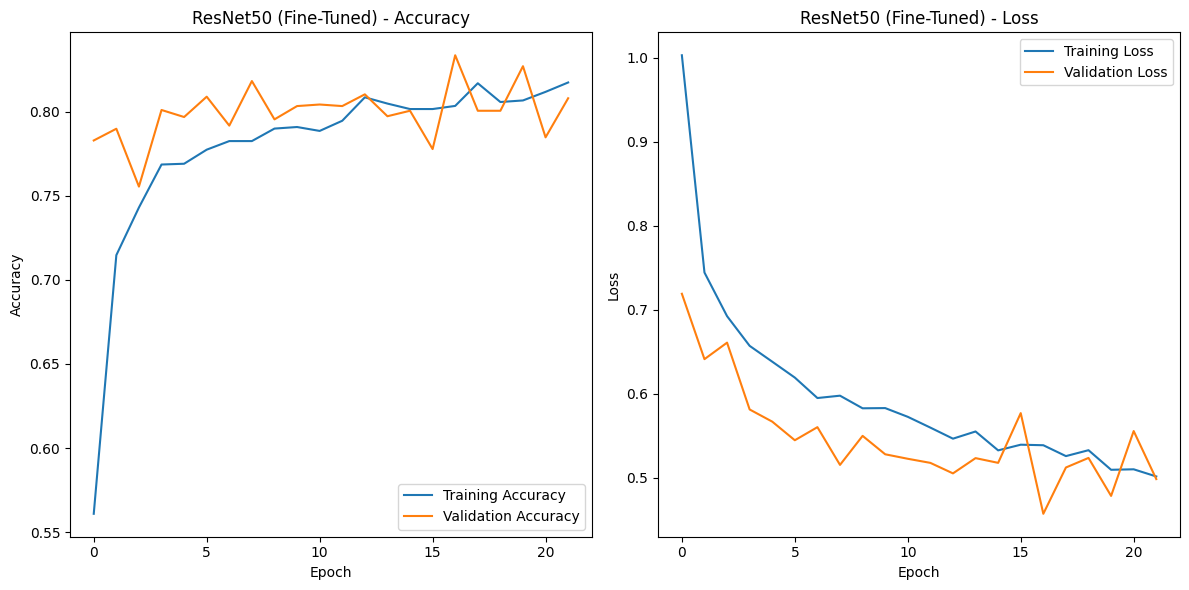


Evaluating Fine-Tuned ResNet50 on Test Set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9139 - loss: 0.3011

ResNet50 Fine-Tuned Test Accuracy: 0.8336
ResNet50 Fine-Tuned Test Loss: 0.4569


In [ ]:
# 학습
print("\nFine-Tuning ResNet50 model...")
resnet_ft_history = resnet_ft_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
plot_history(resnet_ft_history, "ResNet50 (Fine-Tuned)")

# 테스트셋 평가
print("\nEvaluating Fine-Tuned ResNet50 on Test Set...")
loss, accuracy = resnet_ft_model.evaluate(test_generator)
print(f"\nResNet50 Fine-Tuned Test Accuracy: {accuracy:.4f}")
print(f"ResNet50 Fine-Tuned Test Loss: {loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step


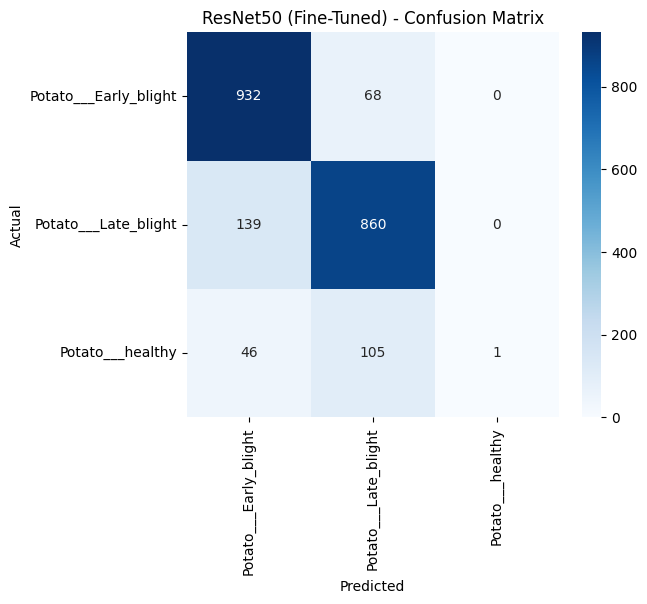


Classification Report for ResNet50 (Fine-Tuned):
                       precision    recall  f1-score   support

Potato___Early_blight       0.83      0.93      0.88      1000
 Potato___Late_blight       0.83      0.86      0.85       999
     Potato___healthy       1.00      0.01      0.01       152

             accuracy                           0.83      2151
            macro avg       0.89      0.60      0.58      2151
         weighted avg       0.85      0.83      0.80      2151


[ResNet50 Fine-Tuning 모델 분석 요약]
- Test Accuracy: 83.36%
- Test Loss: 0.4569


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes
y_pred_probs = resnet_ft_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 (Fine-Tuned) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 분류 리포트
print(f"\nClassification Report for ResNet50 (Fine-Tuned):")
print(classification_report(y_true, y_pred, target_names=class_names))

# 분석 설명
print("\n[ResNet50 Fine-Tuning 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*DenseNet121-전이 학습 (Transfer Learning)*

In [ ]:
# DenseNet121 모델 불러오기 (전이 학습)
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모든 층 동결
for layer in densenet_base.layers:
    layer.trainable = False

# 출력층 구성 (128 뉴런으로 변경)
x = Flatten()(densenet_base.output)
x = Dense(128, activation='relu')(x)  # Dense(128, activation='relu')로 수정
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(class_names), activation='softmax')(x)

# 모델 정의
densenet_model = Model(inputs=densenet_base.input, outputs=output)

# 모델 컴파일
densenet_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



Training DenseNet121 model (Transfer Learning)...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 87s 919ms/step - accuracy: 0.5248 - loss: 1.6735 - val_accuracy: 0.8815 - val_loss: 0.3529
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 474ms/step - accuracy: 0.8373 - loss: 0.4530 - val_accuracy: 0.9284 - val_loss: 0.2214
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.8881 - loss: 0.2943 - val_accuracy: 0.9614 - val_loss: 0.1548
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 476ms/step - accuracy: 0.9241 - loss: 0.2319 - val_accuracy: 0.9712 - val_loss: 0.1153
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 470ms/step - accuracy: 0.9323 - loss: 0.1819 - val_accuracy: 0.9582 - val_loss: 0.1197
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 468ms/step - accuracy: 0.9361 - loss: 0.1643 - val_accuracy: 0.9712 - val_loss: 0.0848
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - accuracy: 0.9595 - loss: 0.1261 - val_accuracy: 0.9800 - val_loss: 0.0665
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 471m

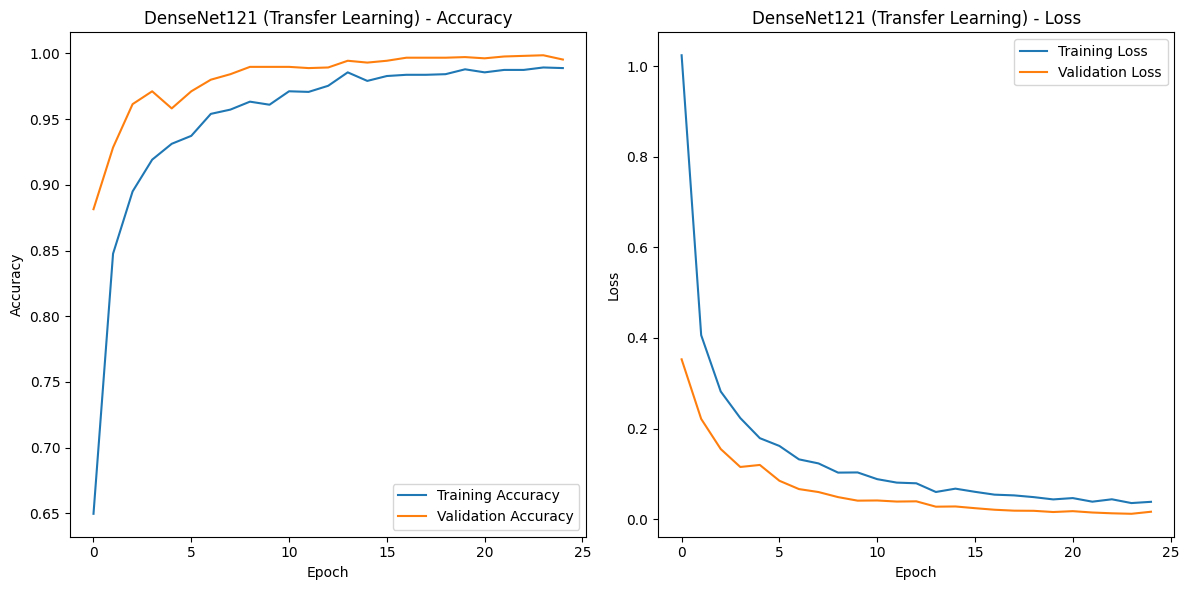


Evaluating DenseNet121 on Test Set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9989 - loss: 0.0111

DenseNet121 Test Accuracy: 0.9986
DenseNet121 Test Loss: 0.0119


In [ ]:
# 학습
print("\nTraining DenseNet121 model (Transfer Learning)...")
densenet_history = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
plot_history(densenet_history, "DenseNet121 (Transfer Learning)")

# 테스트셋 평가
print("\nEvaluating DenseNet121 on Test Set...")
loss, accuracy = densenet_model.evaluate(test_generator)
print(f"\nDenseNet121 Test Accuracy: {accuracy:.4f}")
print(f"DenseNet121 Test Loss: {loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step


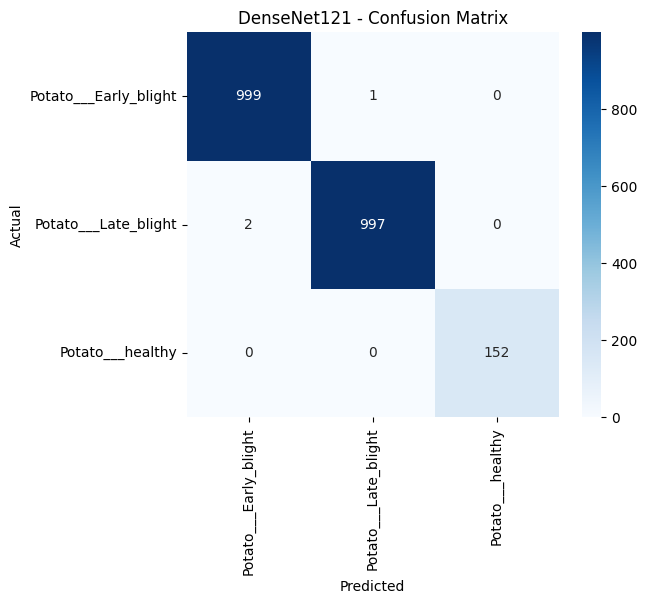


Classification Report for DenseNet121 (Transfer Learning):
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00      1000
 Potato___Late_blight       1.00      1.00      1.00       999
     Potato___healthy       1.00      1.00      1.00       152

             accuracy                           1.00      2151
            macro avg       1.00      1.00      1.00      2151
         weighted avg       1.00      1.00      1.00      2151


[DenseNet121 Transfer Learning 모델 분석 요약]
- Test Accuracy: 99.86%
- Test Loss: 0.0119


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes
y_pred_probs = densenet_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('DenseNet121 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 분류 리포트
print(f"\nClassification Report for DenseNet121 (Transfer Learning):")
print(classification_report(y_true, y_pred, target_names=class_names))

# 분석 설명
print("\n[DenseNet121 Transfer Learning 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*DenseNet121-파인튜닝 (Fine-Tuning)*

In [ ]:
# Fine-Tuning: 마지막 레이어부터 학습 가능하도록 설정
set_trainable = False
for layer in densenet_base.layers:
    if layer.name == 'conv5_block16_2_conv':  # conv5_block16_2_conv부터 학습 시작
        set_trainable = True
    layer.trainable = set_trainable

# 출력층 구성 (128 뉴런으로 변경)
x = Flatten()(densenet_base.output)
x = Dense(128, activation='relu')(x)  # Dense(128, activation='relu')로 수정
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(class_names), activation='softmax')(x)

# Fine-Tuning 모델 정의
densenet_ft_model = Model(inputs=densenet_base.input, outputs=output)

# Fine-Tuning 모델 컴파일
densenet_ft_model.compile(optimizer=Adam(learning_rate=1e-5),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])


Fine-Tuning DenseNet121 model...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 839ms/step - accuracy: 0.5999 - loss: 1.1844 - val_accuracy: 0.8805 - val_loss: 0.3079
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 475ms/step - accuracy: 0.8360 - loss: 0.3937 - val_accuracy: 0.9358 - val_loss: 0.1897
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.8892 - loss: 0.2769 - val_accuracy: 0.9219 - val_loss: 0.1765
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 473ms/step - accuracy: 0.9161 - loss: 0.2292 - val_accuracy: 0.9596 - val_loss: 0.1104
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 468ms/step - accuracy: 0.9264 - loss: 0.1887 - val_accuracy: 0.9675 - val_loss: 0.0912
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 474ms/step - accuracy: 0.9494 - loss: 0.1580 - val_accuracy: 0.9847 - val_loss: 0.0590
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 475ms/step - accuracy: 0.9594 - loss: 0.1156 - val_accuracy: 0.9851 - val_loss: 0.0485
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy

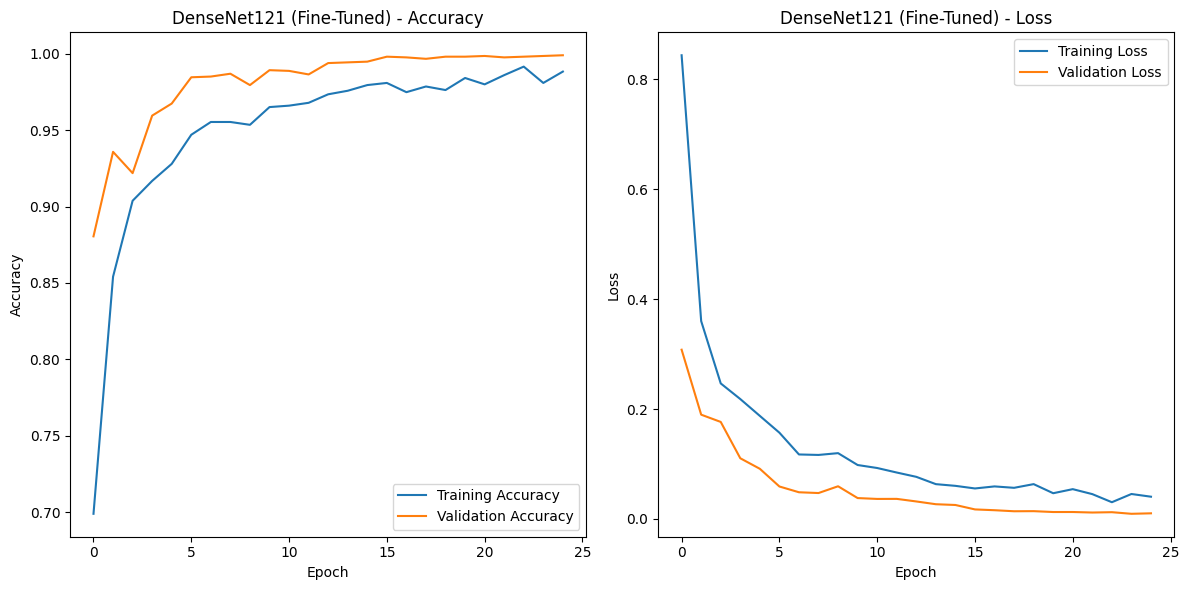


Evaluating Fine-Tuned DenseNet121 on Test Set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9988 - loss: 0.0062

DenseNet121 Fine-Tuned Test Accuracy: 0.9986
DenseNet121 Fine-Tuned Test Loss: 0.0094


In [ ]:
# 학습
print("\nFine-Tuning DenseNet121 model...")
densenet_ft_history = densenet_ft_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
plot_history(densenet_ft_history, "DenseNet121 (Fine-Tuned)")

# 테스트셋 평가
print("\nEvaluating Fine-Tuned DenseNet121 on Test Set...")
loss, accuracy = densenet_ft_model.evaluate(test_generator)
print(f"\nDenseNet121 Fine-Tuned Test Accuracy: {accuracy:.4f}")
print(f"DenseNet121 Fine-Tuned Test Loss: {loss:.4f}")


68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step


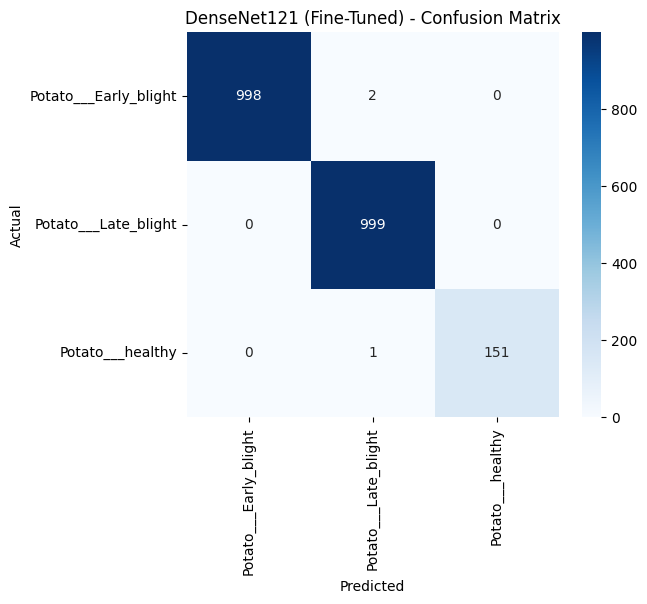


Classification Report for DenseNet121 (Fine-Tuned):
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00      1000
 Potato___Late_blight       1.00      1.00      1.00       999
     Potato___healthy       1.00      0.99      1.00       152

             accuracy                           1.00      2151
            macro avg       1.00      1.00      1.00      2151
         weighted avg       1.00      1.00      1.00      2151


[DenseNet121 Fine-Tuning 모델 분석 요약]
- Test Accuracy: 99.86%
- Test Loss: 0.0094


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes
y_pred_probs = densenet_ft_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('DenseNet121 (Fine-Tuned) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 분류 리포트
print(f"\nClassification Report for DenseNet121 (Fine-Tuned):")
print(classification_report(y_true, y_pred, target_names=class_names))

# 분석 설명
print("\n[DenseNet121 Fine-Tuning 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*EfficientNetB0 모델 - 전이 학습 (Transfer Learning)*

In [ ]:
# EfficientNetB0 모델 불러오기 (전이 학습)
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모든 층 동결
for layer in efficientnet_base.layers:
    layer.trainable = False

# 출력층 구성 (128 뉴런으로 변경)
x = Flatten()(efficientnet_base.output)
x = Dense(128, activation='relu')(x)  # Dense(128, activation='relu')로 수정
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(class_names), activation='softmax')(x)

# 모델 정의
efficientnet_model = Model(inputs=efficientnet_base.input, outputs=output)

# 모델 컴파일
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



Training EfficientNetB0 model (Transfer Learning)...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 89s 901ms/step - accuracy: 0.4168 - loss: 1.0434 - val_accuracy: 0.4644 - val_loss: 0.9030
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - accuracy: 0.4804 - loss: 0.9116 - val_accuracy: 0.4644 - val_loss: 0.9004
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 464ms/step - accuracy: 0.4589 - loss: 0.9202 - val_accuracy: 0.4649 - val_loss: 0.9008
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 468ms/step - accuracy: 0.4586 - loss: 0.9364 - val_accuracy: 0.4644 - val_loss: 0.9062
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 475ms/step - accuracy: 0.4670 - loss: 0.9555 - val_accuracy: 0.4644 - val_loss: 0.9004
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 470ms/step - accuracy: 0.4919 - loss: 0.9100 - val_accuracy: 0.4644 - val_loss: 0.9106
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 464ms/step - accuracy: 0.4679 - loss: 0.9294 - val_accuracy: 0.4644 - val_loss: 0.9020
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 4

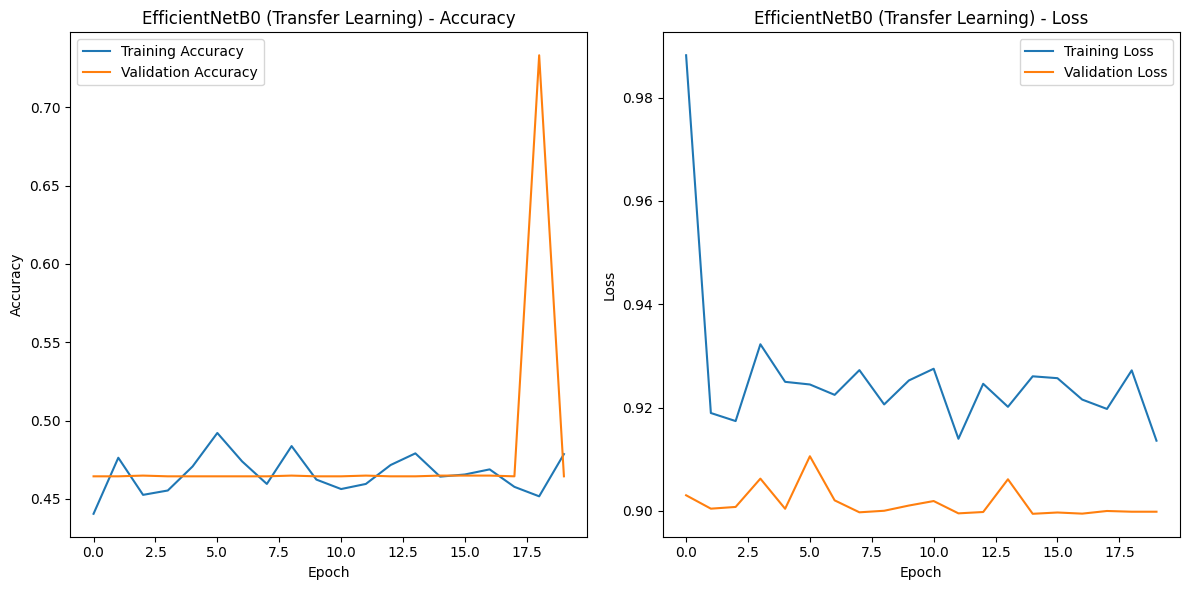


Evaluating EfficientNetB0 on Test Set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.8079 - loss: 0.7698

EfficientNetB0 Test Accuracy: 0.4649
EfficientNetB0 Test Loss: 0.8994


In [ ]:
# 학습
print("\nTraining EfficientNetB0 model (Transfer Learning)...")
efficientnet_history = efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
plot_history(efficientnet_history, "EfficientNetB0 (Transfer Learning)")

# 테스트셋 평가
print("\nEvaluating EfficientNetB0 on Test Set...")
loss, accuracy = efficientnet_model.evaluate(test_generator)
print(f"\nEfficientNetB0 Test Accuracy: {accuracy:.4f}")
print(f"EfficientNetB0 Test Loss: {loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step


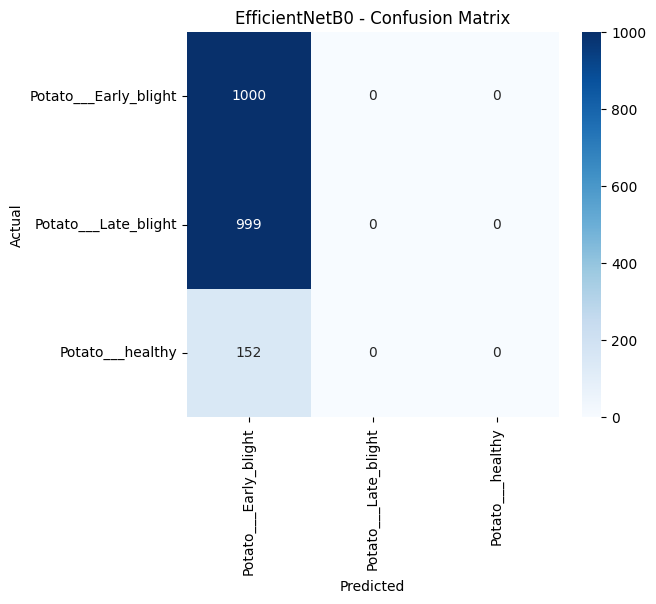


Classification Report for EfficientNetB0 (Transfer Learning):
                       precision    recall  f1-score   support

Potato___Early_blight       0.46      1.00      0.63      1000
 Potato___Late_blight       0.00      0.00      0.00       999
     Potato___healthy       0.00      0.00      0.00       152

             accuracy                           0.46      2151
            macro avg       0.15      0.33      0.21      2151
         weighted avg       0.22      0.46      0.30      2151


[EfficientNetB0 Transfer Learning 모델 분석 요약]
- Test Accuracy: 46.49%
- Test Loss: 0.8994


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes
y_pred_probs = efficientnet_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNetB0 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 분류 리포트
print(f"\nClassification Report for EfficientNetB0 (Transfer Learning):")
print(classification_report(y_true, y_pred, target_names=class_names))

# 분석 설명
print("\n[EfficientNetB0 Transfer Learning 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*EfficientNetB0 모델 - 파인튜닝 (Fine-Tuning)*



In [ ]:
# Fine-Tuning: 마지막 레이어부터 학습 가능하도록 설정
set_trainable = False
for layer in efficientnet_base.layers:
    if layer.name == 'block7a_expand_conv':  # Fine-Tuning 시작하는 레이어
        set_trainable = True
    layer.trainable = set_trainable

# 출력층 구성 (128 뉴런으로 변경)
x = Flatten()(efficientnet_base.output)
x = Dense(128, activation='relu')(x)  # Dense(128, activation='relu')로 수정
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(class_names), activation='softmax')(x)

# Fine-Tuning 모델 정의
efficientnet_ft_model = Model(inputs=efficientnet_base.input, outputs=output)

# Fine-Tuning 모델 컴파일
efficientnet_ft_model.compile(optimizer=Adam(learning_rate=1e-5),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])


Fine-Tuning EfficientNetB0 model...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 791ms/step - accuracy: 0.4603 - loss: 1.0531 - val_accuracy: 0.4644 - val_loss: 0.9389
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 478ms/step - accuracy: 0.4559 - loss: 0.9470 - val_accuracy: 0.4649 - val_loss: 0.9338
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 474ms/step - accuracy: 0.4927 - loss: 0.9540 - val_accuracy: 0.4649 - val_loss: 0.9206
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy: 0.4907 - loss: 0.9341 - val_accuracy: 0.4649 - val_loss: 0.9121
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - accuracy: 0.4922 - loss: 0.9185 - val_accuracy: 0.4649 - val_loss: 0.9155
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.4738 - loss: 0.9401 - val_accuracy: 0.4649 - val_loss: 0.9194
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 469ms/step - accuracy: 0.4823 - loss: 0.9246 - val_accuracy: 0.4649 - val_loss: 0.9069
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 470ms/step - accur

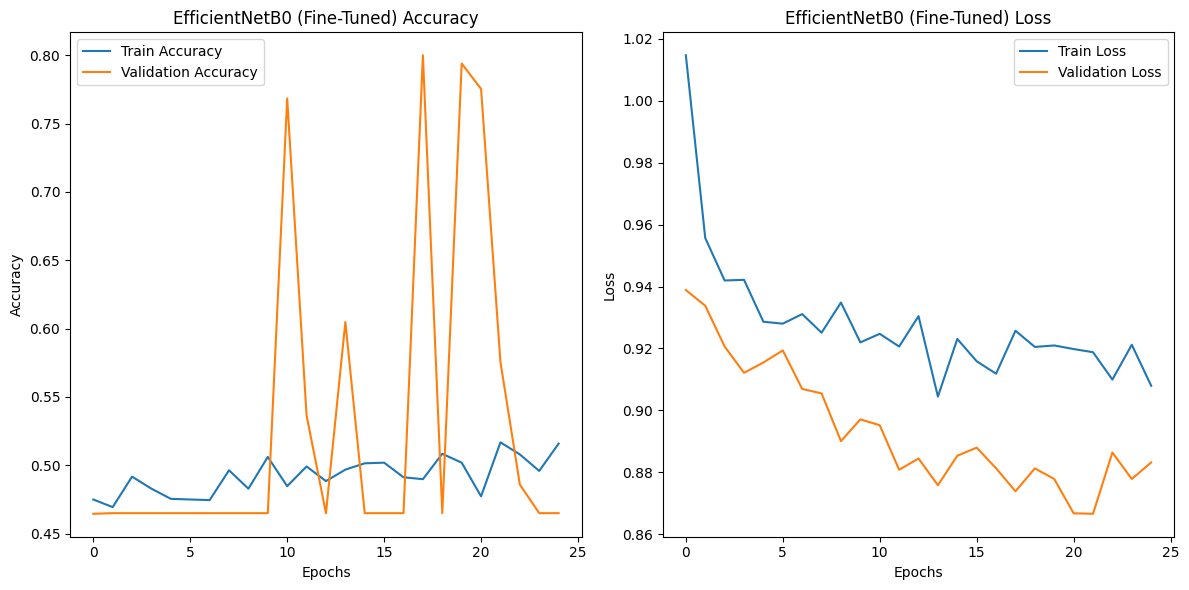


Evaluating Fine-Tuned EfficientNetB0 on Test Set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8529 - loss: 0.7023

EfficientNetB0 Fine-Tuned Test Accuracy: 0.5755
EfficientNetB0 Fine-Tuned Test Loss: 0.8666


In [ ]:
# 학습
print("\nFine-Tuning EfficientNetB0 model...")
efficientnet_ft_history = efficientnet_ft_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
def plot_history(history, model_name):
    # 정확도와 손실 그래프
    plt.figure(figsize=(12, 6))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(efficientnet_ft_history, "EfficientNetB0 (Fine-Tuned)")

# 테스트셋 평가
print("\nEvaluating Fine-Tuned EfficientNetB0 on Test Set...")
loss, accuracy = efficientnet_ft_model.evaluate(test_generator)
print(f"\nEfficientNetB0 Fine-Tuned Test Accuracy: {accuracy:.4f}")
print(f"EfficientNetB0 Fine-Tuned Test Loss: {loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step


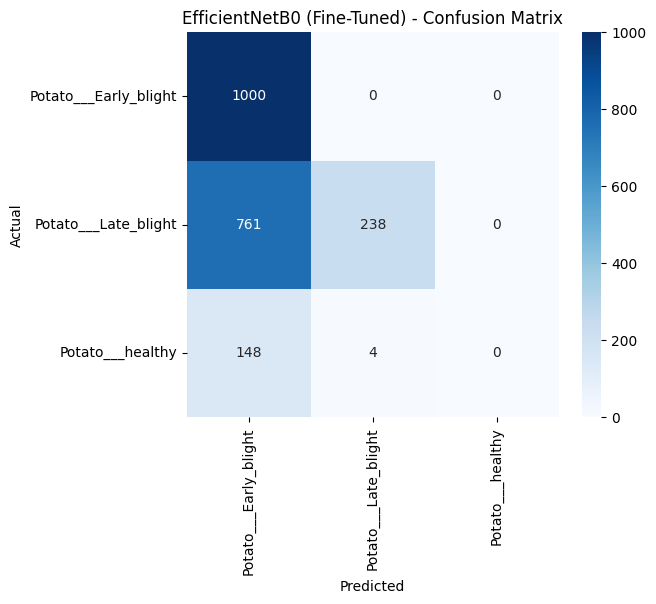


Classification Report for EfficientNetB0 (Fine-Tuned):
                       precision    recall  f1-score   support

Potato___Early_blight       0.52      1.00      0.69      1000
 Potato___Late_blight       0.98      0.24      0.38       999
     Potato___healthy       0.00      0.00      0.00       152

             accuracy                           0.58      2151
            macro avg       0.50      0.41      0.36      2151
         weighted avg       0.70      0.58      0.50      2151


[EfficientNetB0 Fine-Tuning 모델 분석 요약]
- Test Accuracy: 57.55%
- Test Loss: 0.8666


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes
y_pred_probs = efficientnet_ft_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNetB0 (Fine-Tuned) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 분류 리포트
print(f"\nClassification Report for EfficientNetB0 (Fine-Tuned):")
print(classification_report(y_true, y_pred, target_names=class_names))

# 분석 설명
print("\n[EfficientNetB0 Fine-Tuning 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*MobileNetV2-전이 학습 (Transfer Learning)*

In [ ]:
# MobileNetV2 모델 불러오기 (사전 학습된 가중치 사용)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tuning: block_13_expand_conv부터 학습 가능하도록 설정
mobilenet_base.trainable = False  # 먼저 모든 레이어를 동결
set_trainable = False
for layer in mobilenet_base.layers:
    if layer.name == 'block_13_expand_conv':  # 이 지점부터 학습 가능하도록 설정
        set_trainable = True
    layer.trainable = set_trainable

# 출력층 구성
x = Flatten()(mobilenet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Fine-Tuning 모델 정의
mobilenet_ft_model = Model(inputs=mobilenet_base.input, outputs=output)

# 모델 컴파일 (Fine-Tuning일 때 학습률은 작게 설정)
mobilenet_ft_model.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])


Fine-Tuning MobileNetV2 model...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 572ms/step - accuracy: 0.7057 - loss: 0.9173 - val_accuracy: 0.9428 - val_loss: 0.1435
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - accuracy: 0.9175 - loss: 0.2247 - val_accuracy: 0.9744 - val_loss: 0.0674
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 472ms/step - accuracy: 0.9460 - loss: 0.1323 - val_accuracy: 0.9833 - val_loss: 0.0468
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - accuracy: 0.9677 - loss: 0.0938 - val_accuracy: 0.9865 - val_loss: 0.0402
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step - accuracy: 0.9678 - loss: 0.1007 - val_accuracy: 0.9902 - val_loss: 0.0305
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 469ms/step - accuracy: 0.9680 - loss: 0.0885 - val_accuracy: 0.9907 - val_loss: 0.0302
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.9811 - loss: 0.0553 - val_accuracy: 0.9963 - val_loss: 0.0183
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 460ms/step - accuracy

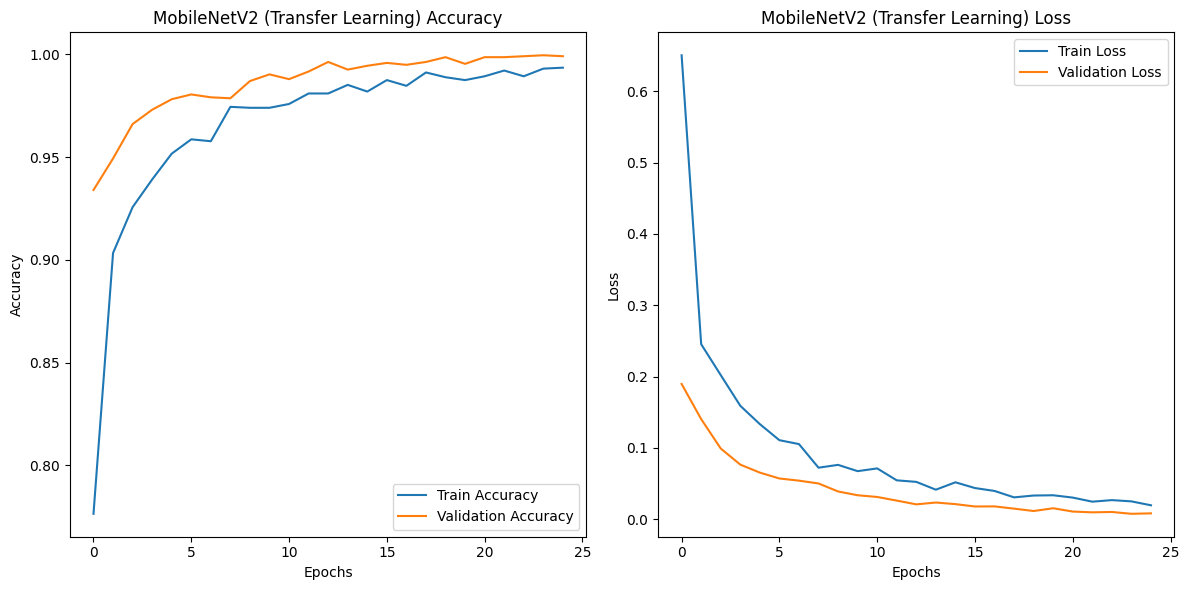

In [ ]:
# 학습
print("\nFine-Tuning MobileNetV2 model...")
mobilenet_ft_history = mobilenet_ft_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 학습 그래프 시각화
plot_history(mobilenet_history, "MobileNetV2 (Transfer Learning)")


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step


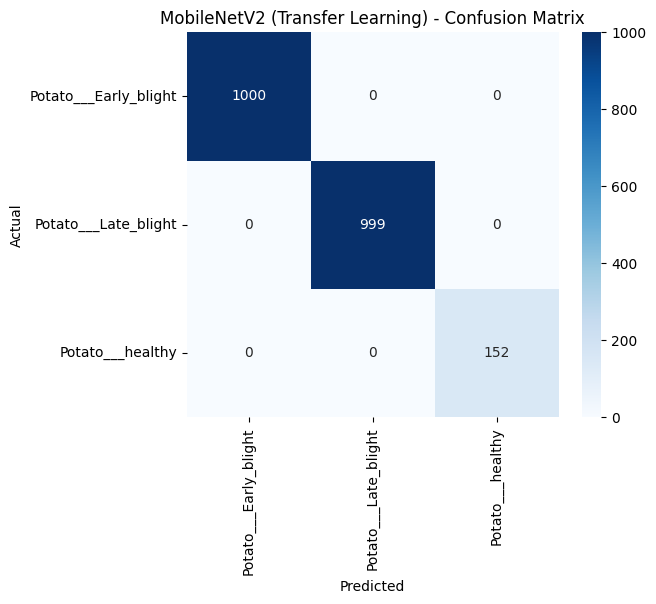

68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 1.0000 - loss: 0.0011

[MobileNetV2 모델 분석 요약]
- Test Accuracy: 100.00%
- Test Loss: 0.0024


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes  # 실제 클래스
y_pred_probs = mobilenet_ft_model.predict(test_generator)  # 예측 확률
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측 레이블

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 클래스 이름을 명시적으로 설정
class_names = list(test_generator.class_indices.keys())  # test_generator에서 클래스 이름을 가져옵니다.

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,  # 클래스 이름 설정
            yticklabels=class_names)  # 클래스 이름 설정
plt.title('MobileNetV2 (Transfer Learning) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 테스트셋 평가 (정확도 및 손실 계산)
loss, accuracy = mobilenet_ft_model.evaluate(test_generator)
print("\n[MobileNetV2 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*MobileNetV2 파인튜닝 (Fine-Tuning)*

In [ ]:
# Fine-Tuning: block_13_expand_conv부터 학습 가능하도록 설정
mobilenet_base.trainable = False  # 먼저 모든 레이어를 동결
set_trainable = False
for layer in mobilenet_base.layers:
    if layer.name == 'block_13_expand_conv':  # 이 지점부터 학습 가능하도록 설정
        set_trainable = True
    layer.trainable = set_trainable

# 출력층 구성
x = Flatten()(mobilenet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout 추가로 과적합 방지
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Fine-Tuning 모델 정의
mobilenet_ft_model = Model(inputs=mobilenet_base.input, outputs=output)

# 모델 컴파일 (Fine-Tuning일 때 학습률은 작게 설정)
mobilenet_ft_model.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])


Fine-Tuning MobileNetV2 model...
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 575ms/step - accuracy: 0.7145 - loss: 0.9529 - val_accuracy: 0.9582 - val_loss: 0.1228
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 462ms/step - accuracy: 0.9377 - loss: 0.1660 - val_accuracy: 0.9665 - val_loss: 0.0909
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - accuracy: 0.9504 - loss: 0.1420 - val_accuracy: 0.9809 - val_loss: 0.0560
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - accuracy: 0.9636 - loss: 0.0941 - val_accuracy: 0.9833 - val_loss: 0.0463
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 476ms/step - accuracy: 0.9720 - loss: 0.0716 - val_accuracy: 0.9898 - val_loss: 0.0313
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0.9786 - loss: 0.0646 - val_accuracy: 0.9870 - val_loss: 0.0392
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 469ms/step - accuracy: 0.9757 - loss: 0.0611 - val_accuracy: 0.9935 - val_loss: 0.0254
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 465ms/step - accuracy

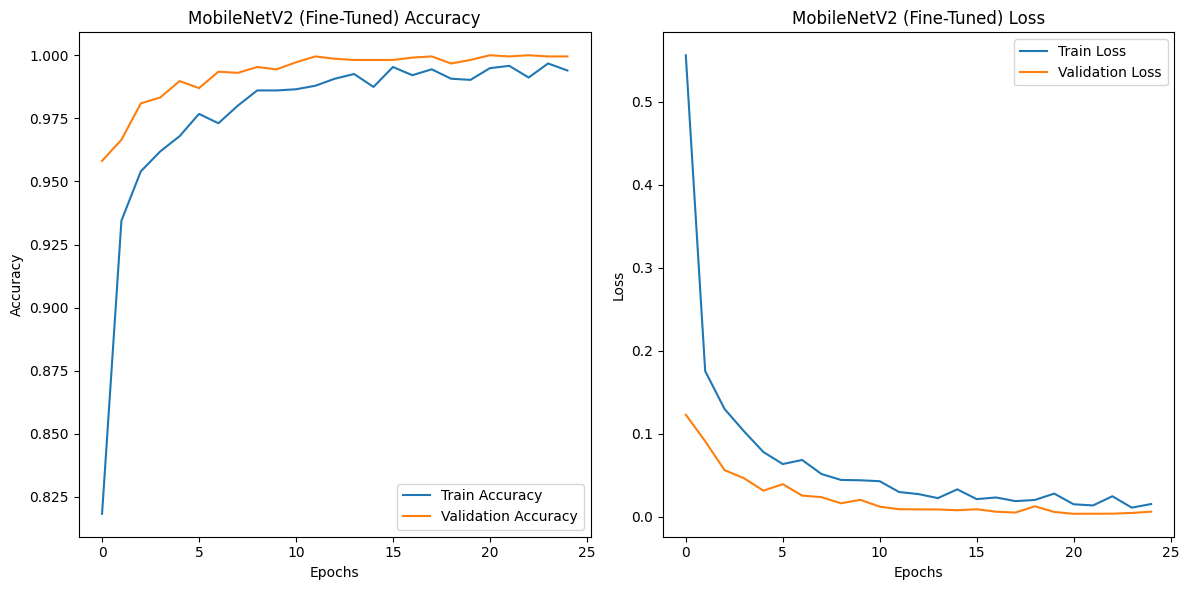

In [ ]:
# 학습
print("\nFine-Tuning MobileNetV2 model...")
mobilenet_ft_history = mobilenet_ft_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)
# 학습 그래프 시각화
plot_history(mobilenet_ft_history, "MobileNetV2 (Fine-Tuned)")

68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step


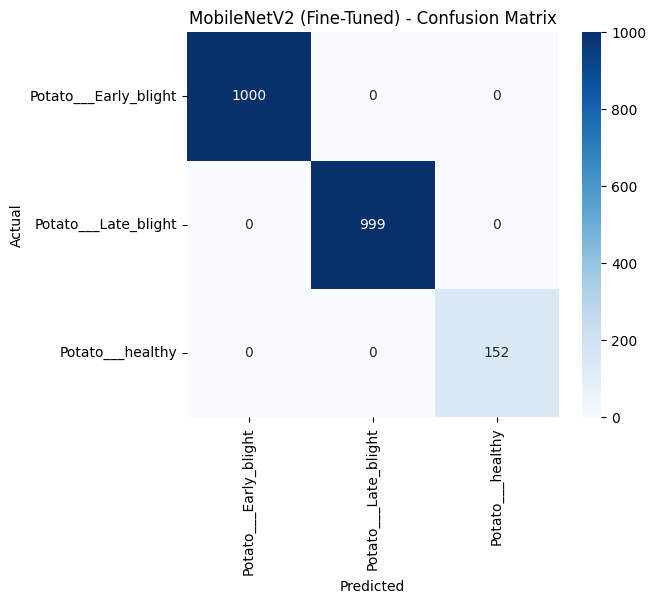

68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 1.0000 - loss: 0.0020

[MobileNetV2 모델 분석 요약]
- Test Accuracy: 100.00%
- Test Loss: 0.0035


In [ ]:
# 예측 및 혼동 행렬
y_true = test_generator.classes  # 실제 클래스
y_pred_probs = mobilenet_ft_model.predict(test_generator)  # 예측 확률
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측 레이블

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 클래스 이름을 명시적으로 설정
class_names = list(test_generator.class_indices.keys())  # test_generator에서 클래스 이름을 가져옵니다.

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,  # 클래스 이름 설정
            yticklabels=class_names)  # 클래스 이름 설정
plt.title('MobileNetV2 (Fine-Tuned) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 테스트셋 평가 (정확도 및 손실 계산)
loss, accuracy = mobilenet_ft_model.evaluate(test_generator)
print("\n[MobileNetV2 모델 분석 요약]")
print(f"- Test Accuracy: {accuracy:.2%}")
print(f"- Test Loss: {loss:.4f}")

#*앙상블(소프트 보팅)*

In [ ]:
# 각 모델의 예측 확률을 평균내어 소프트 보팅 방식으로 앙상블
def get_ensemble_predictions(models, test_generator):
    # test_generator에서 배치 크기 및 이미지 수 가져오기
    num_images = test_generator.samples  # 테스트 데이터셋의 전체 이미지 수
    batch_size = test_generator.batch_size  # 배치 크기

    # 예측 결과 저장 변수
    predictions = np.zeros((num_images, len(test_generator.class_indices)))

    # 각 모델로 예측을 수행하고 확률을 더함
    for model in models:
        # 모델 예측 (배치 단위로 예측)
        preds = model.predict(test_generator, batch_size=batch_size, verbose=1)
        predictions += preds

    # 모델 예측 확률을 평균내고, 가장 높은 확률을 가진 클래스를 선택
    return np.argmax(predictions / len(models), axis=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step


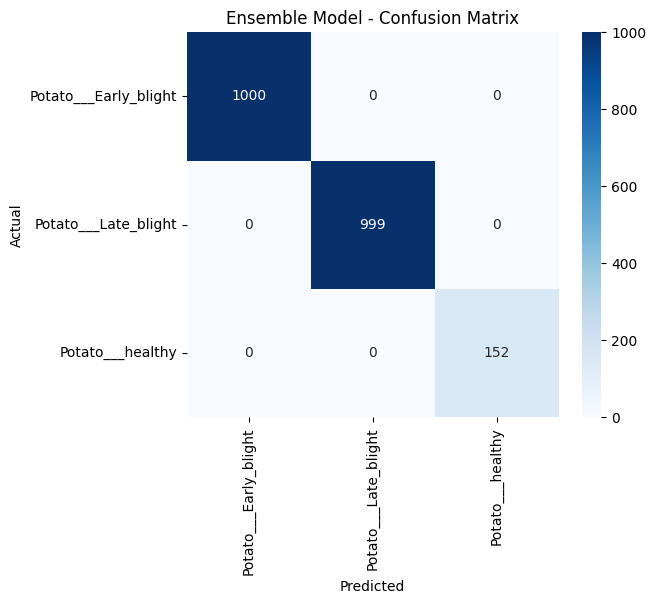


[Ensemble 모델 분석 요약]
- Test Accuracy: 100.00%


In [ ]:
# 예시로 VGG16, DenseNet121, MobileNetV2 모델 로딩
vgg_model = vgg_ft_model  # Replace ... with the actual VGG16 model object
densenet_model = densenet_ft_model # Replace ... with the actual DenseNet121 model object
mobilenet_model = mobilenet_ft_model  # Replace ... with the actual MobileNetV2 model object

models = [vgg_model, densenet_model, mobilenet_model]

# 테스트 데이터에 대해 앙상블 예측 수행
ensemble_predictions = get_ensemble_predictions(models, test_generator)

# 실제 클래스 (y_true)와 예측된 클래스 (ensemble_predictions)를 비교하여 혼동 행렬 생성
y_true = test_generator.classes
cm = confusion_matrix(y_true, ensemble_predictions)

# 클래스 이름을 명시적으로 설정
class_names = list(test_generator.class_indices.keys())

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,  # 클래스 이름 설정
            yticklabels=class_names)  # 클래스 이름 설정
plt.title('Ensemble Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 모델 평가 (정확도 및 손실 계산)
ensemble_accuracy = np.mean(ensemble_predictions == y_true)
print("\n[Ensemble 모델 분석 요약]")
print(f"- Test Accuracy: {ensemble_accuracy:.2%}")

#**SQLite**

In [22]:
# SQLite 데이터베이스 연결
conn = sqlite3.connect('training_history.db')
cursor = conn.cursor()

# 학습 기록 테이블 생성
cursor.execute('''
CREATE TABLE IF NOT EXISTS training_history (
    epoch INTEGER,
    start_time TEXT,
    end_time TEXT,
    loss REAL,
    accuracy REAL
)
''')

In [23]:
# 학습 기록 저장 함수
def save_training_history(epoch, start_time, end_time, loss, accuracy):
    cursor.execute('''
    INSERT INTO training_history (epoch, start_time, end_time, loss, accuracy)
    VALUES (?, ?, ?, ?, ?)
    ''', (epoch, start_time, end_time, loss, accuracy))
    conn.commit()

In [24]:
# 학습 시작 시간
start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# 예시로 1에포크 학습 후, 학습 종료 시간과 결과 기록
epoch = 1
end_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
loss = 0.2  # 예시 손실 값
accuracy = 0.9  # 예시 정확도 값

In [25]:
# 학습 기록 저장
save_training_history(epoch, start_time, end_time, loss, accuracy)

# 학습 기록 조회
cursor.execute('SELECT * FROM training_history')
records = cursor.fetchall()
for record in records:
    print(record)

# 연결 종료
conn.close()

(1, '2025-03-26 08:26:35', '2025-03-26 08:26:35', 0.2, 0.9)
